In [1]:
from src import attributes as a
%load_ext autoreload
%autoreload 2

In [2]:
# Global Variables
stock_name = 'intc' # ticker symbol
train = 1 # 1 for train, 0 for pass
days_ahead = 1 # for predicting 1 day ahead
cv = 5 # number of cross validation folds
model_name = 'Random Forest Classifier' # for display on charts, not a tuning parameter

In [3]:
# Extract, Transform, Load, and Train Test Split
# aapl start date: 12/12/1980, trained 12/23/20
# tsla start date: 06/29/2010, trained 12/23/20
# vbiv start date: 09/04/2002, trained 12/23/20
# vgt start date: 01/26/2004, trained 12/23/20
# idex start date: 05/23/2007, trained 12/23/20
# iyw start date: 05/15/2000, trained 12/23/20
# 
start_dates = {'aapl':'12/12/1980' # Updated 1/1/21
               , 'acy': '01/18/1998' # Updated 1/1/21
               , 'amd': '03/17/1980' # Updated 1/1/21
               , 'baba': '09/15/2014' # Updated 1/1/21
               , 'bac': '02/19/1973' # Updated 1/1/21
               , 'crm': '06/23/2004' # Updated 1/1/21
               , 'esgv': '09/16/2018' # Updated 1/1/21
               , 'goog': '08/16/2004' # Updated 1/1/21
               , 'ibm': '01/02/1962' # Updated 1/1/21
               , 'idex': '05/23/2007' # Updated 1/1/21
               , 'intc': '03/16/1980' # Updated 1/1/21
               , 'iyw': '05/15/2000'
               , 'ma': '05/21/2006' # Updated 1/1/21
               , 'msft': '03/10/1986'
               , 'nio': '09/10/2018'
               , 'nvda': '01/22/1999'
               , 'pypl': '07/05/2015'
               , 'tsla': '06/29/2010'
               , 'v': '03/16/2008'
               , 'vbiv': '09/04/2002'
               , 'vgt': '01/26/2004'
              }
X_train, X_test, y_train, y_test, stock_df = a.data(stock_name, start_dates[stock_name], days_ahead)

In [4]:
stock_df.tail(10)

,High,Low,Open,Close,Volume,Adj Close,oc,hl,adj,5stdev_adj,5sma_adj,direction
Date,,,,,,,,,,,,
2020-12-17,51.320000,50.220001,51.150002,50.650002,26399000.0,50.650002,0.009775,0.021904,-0.009194,0.011169,0.001597,-1
2020-12-18,50.680000,47.110001,50.570000,47.459999,119298400.0,47.459999,0.061499,0.075780,-0.062981,0.031512,-0.008890,1
2020-12-21,46.450001,45.240002,46.320000,46.360001,53775700.0,46.360001,-0.000864,0.026746,-0.023177,0.028816,-0.016502,1
2020-12-22,46.340000,45.770000,46.250000,46.169998,32171200.0,46.169998,0.001730,0.012454,-0.004098,0.027584,-0.018114,1
2020-12-23,47.029999,46.070000,46.169998,46.570000,22564200.0,46.570000,-0.008664,0.020838,0.008664,0.027531,-0.018157,1
2020-12-24,47.090000,46.340000,46.599998,47.070000,11865600.0,47.070000,-0.010086,0.016185,0.010737,0.030442,-0.014171,-1
2020-12-28,47.639999,46.860001,47.189999,47.070000,21269200.0,47.070000,0.002543,0.016645,0.000000,0.013527,-0.001575,1
2020-12-29,50.669998,46.490002,47.220001,49.389999,84531400.0,49.389999,-0.045955,0.089912,0.049288,0.021226,0.012918,-1
2020-12-30,49.189999,48.560001,49.110001,48.750000,37385400.0,48.750000,0.007330,0.012974,-0.012958,0.023272,0.011146,1


In [5]:
# GridSerach to find best hyperparameters to prevent overfitting, can be commented out once trained
if train == 1:
    a.rfc_GridSearch(X_train, y_train, stock_name, days_ahead, cv)
elif train == 0:
    pass

/home/david/.local/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [       nan        nan        nan ... 0.71432128 0.71432128 0.71432128]
  warnings.warn(


In [6]:
# Load RandomForextClassifier Model
rfc_model, y_pred, y_probs = a.rfc(X_train, X_test, y_train, stock_name, days_ahead)

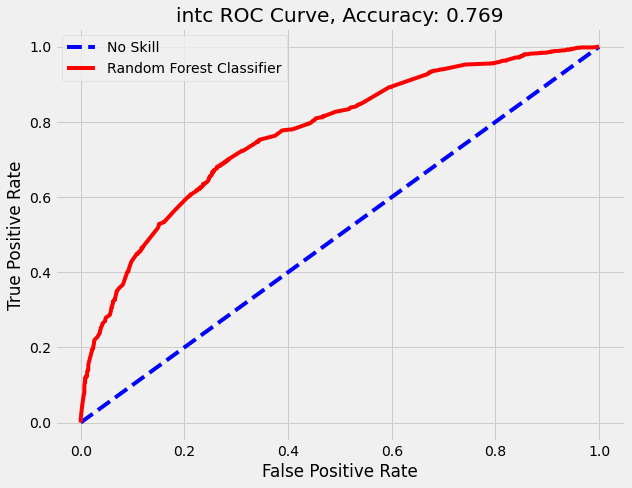

In [7]:
# ROC Curve
a.roc_plot(y_test, y_probs, stock_name, model_name)

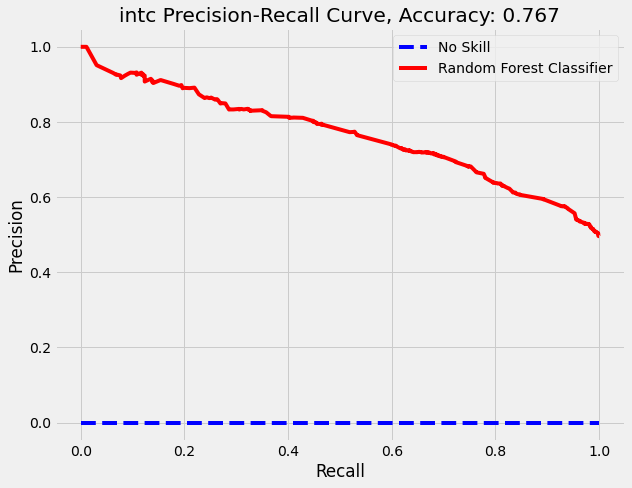

In [8]:
# Precision Recall Curve
a.prec_recall(y_test, y_probs, stock_name, model_name)

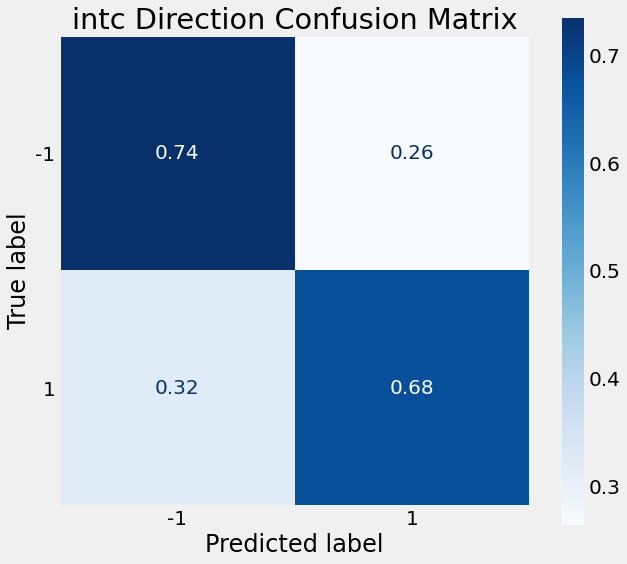

In [9]:
# Confusion Matrix
a.confusion_matrix(rfc_model, X_test, y_test, stock_name)

In [10]:
# Cross Validation
a.cross_validation(rfc_model
                   , stock_df[['oc', 'hl', '5stdev_adj', '5sma_adj']]
                   , stock_df['direction']
                   , cv = 5
                  )

'5 Fold Cross-Validation Score for First RF Model: 0.70028402588485'

### Prediction...

In [11]:
# Prediction, use last day of data
stock_df.iloc[-1]

High          5.019000e+01
Low           4.872000e+01
Open          4.875000e+01
Close         4.982000e+01
Volume        2.856550e+07
Adj Close     4.982000e+01
oc           -2.194871e-02
hl            3.017236e-02
adj           2.194871e-02
5stdev_adj    2.367298e-02
5sma_adj      1.380309e-02
direction    -1.000000e+00
Name: 2020-12-31 00:00:00, dtype: float64

In [12]:
import numpy as np
last = stock_df[['oc', 'hl', '5stdev_adj', '5sma_adj']].iloc[-1]
last

oc           -0.021949
hl            0.030172
5stdev_adj    0.023673
5sma_adj      0.013803
Name: 2020-12-31 00:00:00, dtype: float64

In [13]:
stock_df['adj'].describe()

count    10283.000000
mean         0.000857
std          0.025188
min         -0.220330
25%         -0.012052
50%          0.000000
75%          0.013724
max          0.263780
Name: adj, dtype: float64

In [14]:
if rfc_model.predict(np.array(last).reshape(1, -1))[0] == 1:
    print(f'Buy {stock_name}')
else:
    print(f'Sell or hold {stock_name}')

Sell or hold intc


### Strategy Returns...

In [15]:
# returns on strategy column
stock_df['prediction'] = rfc_model.predict(stock_df[['oc', 'hl', '5stdev_adj', '5sma_adj']])
stock_df['returns'] = stock_df['adj'].shift(-1, fill_value = stock_df['adj'].median()) * stock_df['prediction']

In [16]:
stock_df.tail(5)

,High,Low,Open,Close,Volume,Adj Close,oc,hl,adj,5stdev_adj,5sma_adj,direction,prediction,returns
Date,,,,,,,,,,,,,,
2020-12-24,47.090000,46.340000,46.599998,47.070000,11865600.0,47.070000,-0.010086,0.016185,0.010737,0.030442,-0.014171,-1,-1,-0.000000
2020-12-28,47.639999,46.860001,47.189999,47.070000,21269200.0,47.070000,0.002543,0.016645,0.000000,0.013527,-0.001575,1,1,0.049288
2020-12-29,50.669998,46.490002,47.220001,49.389999,84531400.0,49.389999,-0.045955,0.089912,0.049288,0.021226,0.012918,-1,-1,0.012958
2020-12-30,49.189999,48.560001,49.110001,48.750000,37385400.0,48.750000,0.007330,0.012974,-0.012958,0.023272,0.011146,1,1,0.021949
2020-12-31,50.189999,48.720001,48.750000,49.820000,28565500.0,49.820000,-0.021949,0.030172,0.021949,0.023673,0.013803,-1,-1,-0.000000


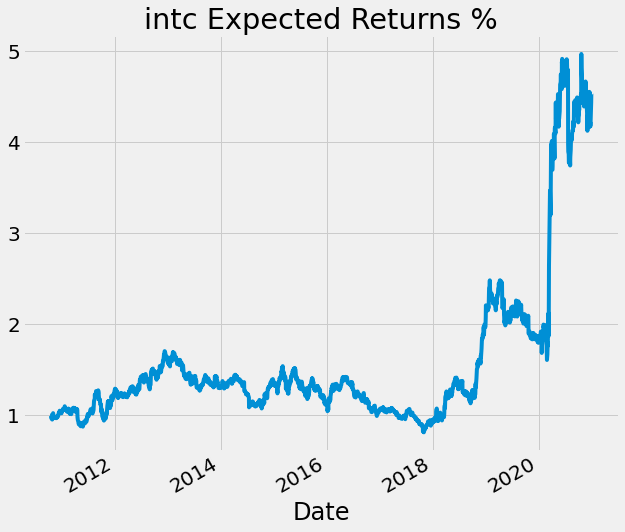

In [17]:
# Don't trade every day!
import matplotlib.pyplot as plt
test_length = len(y_test)
(stock_df['returns'][-test_length:] + 1).cumprod().plot()
plt.title(f'{stock_name} Expected Returns %');

In [18]:
# Model returns if bought on predictions of 1
returns_on_ones = []
for idx in range(-test_length, 0):
    if stock_df['prediction'][idx] == 1:
        returns_on_ones.append(1 + stock_df['returns'][idx])

returns = 1
for x in returns_on_ones:
    returns *= x
returns

4.8559528845338775

In [19]:
# multiple times original investment, not bad but...

In [20]:
# If purchased in 2012 and left it until now
test_idx = int(len(stock_df)*0.75)
(stock_df['Close'][-1] - stock_df['Close'][-test_idx]) /stock_df['Close'][-test_idx]

32.04124332091969

In [21]:
# Buy and hold strategy beats RandomForestClassifier in this study

# Special thanks to Shagufta Tahsildar at https://blog.quantinsti.com/random-forest-algorithm-in-python/